In [20]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
def plot_boxes(T, t, n, labels):
    fig, ax = plt.subplots()
    for i in range(n):
        ax.plot(t, T[:, i], label=f"{labels[i]}")

    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Temperature (K)')
    ax.legend()
    fig.tight_layout()
    return

n = 2
labels = ['Atmosphere','Ocean']

# Define the ODE system
def coup_n_box(C, F, L):
    f = np.array([0.0]*len(L))
    f[0] = 1.0
    return -np.dot(L, C) + f * F

# Define the ODE system
def uncoup_n_box(B, f, F, lambda_diag):
    # The equation is the same for all n components
    return -lambda_diag * B + f * F

### Uncoupled 2-Box Model
$\frac{\partial}{\partial t} B_i = -\lambda_i B_i + f_i F(t)$

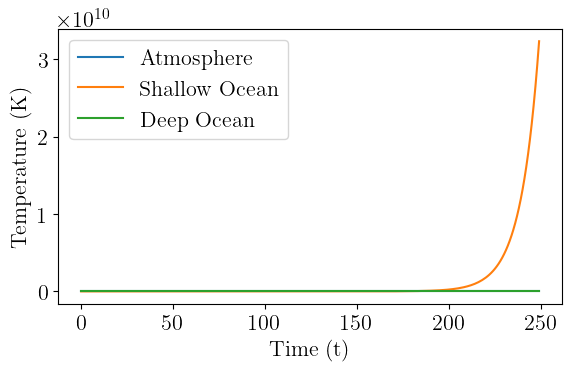

In [22]:
# ODE parameters
rho_w = 1e3
c_w = 4e3
h = np.array([10.0, 150.0, 1500.0])
C = rho_w*c_w*h/3.154e7 # convert from seconds to years
lam = np.array([-0.86, -2.0, -0.67])
T0 = 0 # K
F0 = 1

f = np.array([1.0, 1.0, 1.0])  # f_i values
F = 1.0  # F is a constant

# Define the time step and time array
dt = 1
t_final = 250
t = np.arange(0, t_final, dt)

# Initial conditions for B (2 components)
B = np.zeros((len(t), 3))
B[0] = np.array([0.0, 0.0, 0.0])  # Initial values for B1 and B2

# Define the ODE system
def uncoup_3_box(B, f, F, lam, C):
    return -np.divide(lam * B, C) + f * np.divide(F, C)

# Euler's method to solve the ODE
for i in range(1, len(t)):
    B[i] = B[i-1] + uncoup_3_box(B[i-1], f, F, lam, C) * dt

B[:,0] = 0
labels = ['Atmosphere','Shallow Ocean','Deep Ocean']
plot_boxes(B, t, 3, labels)

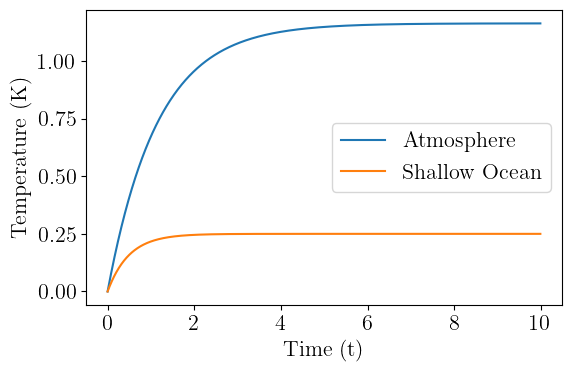

In [23]:
# Define the parameters and initial conditions
lambda_diag = np.array([0.86, 2.0])  # Diagonal elements of the lambda matrix

f = np.array([1.0, 0.5])  # f_i values
F = 1.0  # F is a constant

# Define the time step and time array
dt = 0.01
t_final = 10.0
t = np.arange(0, t_final, dt)

# Initial conditions for B (2 components)
B = np.zeros((len(t), 2))
B[0] = np.array([0.0, 0.0])  # Initial values for B1 and B2

# Define the ODE system
def uncoup_2_box(B, f, F, lambda_diag):
    return -lambda_diag * B + f * F

# Euler's method to solve the ODE
for i in range(1, len(t)):
    B[i] = B[i-1] + uncoup_2_box(B[i-1], f, F, lambda_diag) * dt

plot_boxes(B, t, n, labels)

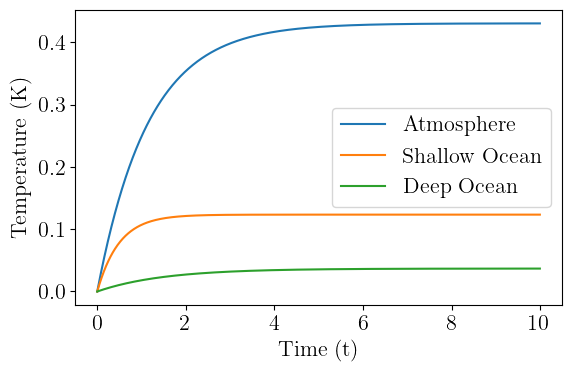

In [24]:
# Define the parameters and initial conditions
lambda_diag = np.array([0.86, 2.0, 0.67])  # Diagonal elements of the lambda matrix (can be of any length)
f = np.array([1/10, 1/15, 1/150])  # f_i values (same length as lambda_diag)
F = 3.7  # F is a constant

# Number of boxes (components) is determined by the length of lambda_diag
n = len(lambda_diag)

# Define the time step and time array
dt = 0.01
t_final = 10.0
t = np.arange(0, t_final, dt)

# Initial conditions for B (n components)
B = np.zeros((len(t), n))
B[0] = np.zeros(n)  # Initial values for B components (all set to 0)

# Euler's method to solve the ODE
for i in range(1, len(t)):
    B[i] = B[i-1] + uncoup_n_box(B[i-1], f, F, lambda_diag) * dt

labels = ['Atmosphere','Shallow Ocean','Deep Ocean']
plot_boxes(B, t, n, labels)


In [25]:
def uncoup_to_coup(Lambda, f):
    n = len(f)

    # Construct G_inv such that G_inv[:, 0] = f
    G_inv = np.zeros((n, n))
    G_inv[:, 0] = f

    # The remaining entries of G_inv can be chosen arbitrarily, but must form an invertible matrix
    # For simplicity, we can fill the rest with some identity-like structure
    for i in range(1, n):
        G_inv[i, i] = 1

    # Now compute G as the inverse of G_inv
    G = np.linalg.inv(G_inv)

    # Construct L as G * Lambda * G_inv
    L = G @ np.diag(Lambda) @ G_inv

    return L, G, G_inv

In [27]:
L

array([[ 8.60000000e-01,  0.00000000e+00,  0.00000000e+00],
       [ 7.60000000e-02,  2.00000000e+00,  0.00000000e+00],
       [-1.26666667e-03,  0.00000000e+00,  6.70000000e-01]])

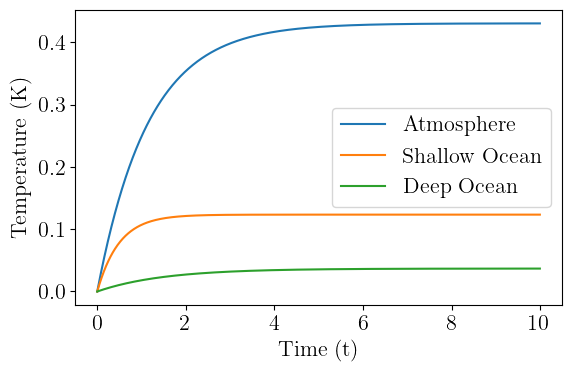

In [26]:
L, G, G_inv = uncoup_to_coup(lambda_diag, f)

# Initial conditions for C (n components)
C = np.zeros((len(t), n))
C[0] = np.zeros(n)  # Initial values for C components (all set to 0)

# Euler's method to solve the ODE
for i in range(1, len(t)):
  C[i] = C[i-1] + coup_n_box(C[i-1], F, L) * dt

#plot_boxes(C, t, n, labels)

for i in range(1, len(t)):
    C[i] = np.dot(G_inv, C[i])

scale = B[-1][0]/C[-1][0]
C = C*scale

plot_boxes(C, t, n, labels)


### Coupled 2-Box Model
$\frac{\partial}{\partial t} C_i = -L_{i,j} C_i + \delta_{1,i} F(t)$

IndexError: index 2 is out of bounds for axis 1 with size 2

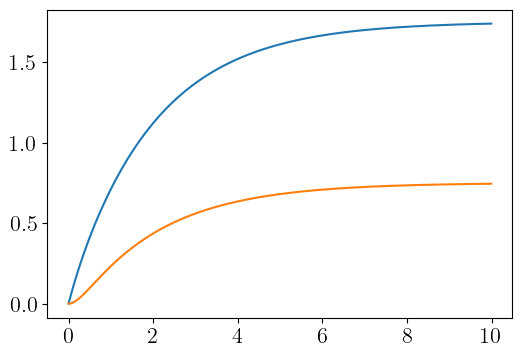

In [135]:
a_1, a_2, a_3 = 1.0, 1.5, 2.0

# Define the parameters and initial conditions
L = np.array([[a_1, -a_1], [-a_2, a_2 + a_3]])  # L matrix (non-diagonal)
F = 1.0  # F is a constant

# Define the time step and time array
dt = 0.01
t_final = 10.0
t = np.arange(0, t_final, dt)

# Initial conditions for C (2 components)
C = np.zeros((len(t), 2))
C[0] = np.array([0.0, 0.0])  # Initial values for C1 and C2

# Euler's method to solve the ODE
for i in range(1, len(t)):
    C[i] = C[i-1] + coup_n_box(C[i-1], F, L) * dt

plot_boxes(C, t, n, labels)


### Making the coupled model behave like the uncoupled
Start from the coupled model: $\frac{\partial}{\partial t} C_i = -L_{i,j} C_i + \delta_{1,i} F(t)$

We can diagonalize the linear operator using its eigenvalues and eigenvectors: $-L_{i,j} = g_{i,k}\Lambda_{k,m}g^{-1}_{m,j}$

Multiplying our governing equation by $g^{-1}_{m,j}$: $\frac{\partial}{\partial t} g^{-1}_{j,i}C_i = \Lambda_{j,k}g^{-1}_{k,m} C_m + g^{-1}_{j,1} F(t)$

This is now identical to our uncoupled system, if we select our eigenvalues such that $\text{eig}(L_{i,j}) = \lambda_i$ and our eigenvectors to project $g^{-1}_{i,1} = f_i$.

We can write: $\frac{\partial}{\partial t} \hat{B}_j = -\hat{\lambda}_j \hat{B}_j + \hat{f}_j F(t)$, where $\hat{B}_j = g^{-1}_{j,i}C_i, \, \hat{f}_j = g^{-1}_{i,1}$.

To be able to actually implement this, we need to solve for $L_{i,j}$ such that its eigenvalues and eigenvectors fulfill the above requirements. From there, we then simply solve the system in the same way we would the coupled, with the new linear operator.

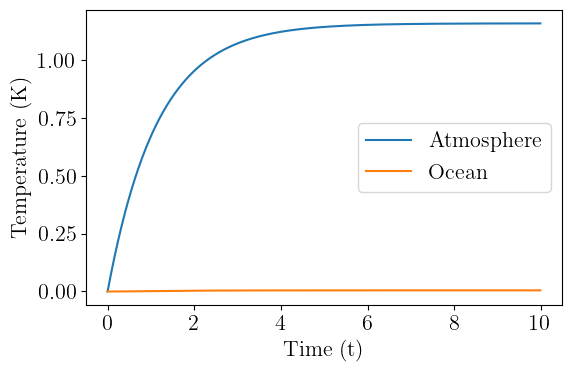

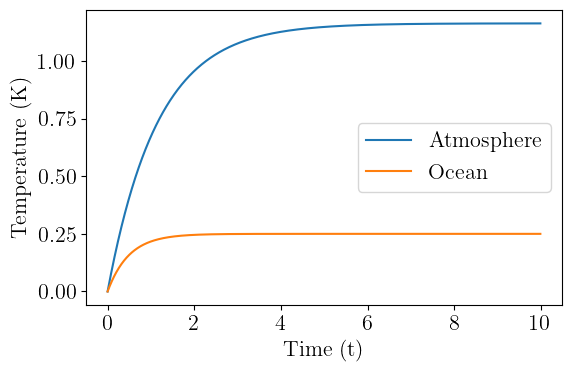

In [115]:
# Start with knowns from the physical system
# Placeholder values
alpha = 1.0
r = 0.01 # l_1/l_2
lam_1 = lambda_diag[0]
lam_2 = lambda_diag[1]

# calculate the discriminant
a = 1 + r
b = -(lam_1 + lam_2)
c = lam_1*lam_2
d = (b**2) - (4*a*c)

# find two solutions
sol1 = (-b - np.sqrt(d))/(2*a)
sol2 = (-b + np.sqrt(d))/(2*a)

l_1 = sol1
l_3 = l_1/(lam_1*lam_2)
l_2 = lam_1 + lam_2 - l_1 - l_3

g_0 = (l_1 - lam_2)/(lam_1 - lam_2)*alpha/f[0]
g_1 = (lam_1 - l_1)/(lam_1 - lam_2)*alpha/f[1]
G = np.array([[g_0, g_1],[g_0*(1 - lam_1/l_1), g_1*(1 - lam_2/l_1)]])
G_inv = np.array([[1/g_0*(l_1 - lam_2), -l_1/g_0],[-1/g_1*(l_1 - lam_1), l_1/g_1]])/(lam_1 - lam_2)

# Initial conditions for B_hat
B_hat = np.zeros((len(t), 2))
B_hat[0] = np.array([0.0, 0.0])
f_del = np.array([alpha, 0.0])

lam = np.array([[lam_1, 0], [0, lam_2]])
L_hat = np.dot(np.dot(G, lam), G_inv)

for i in range(1, len(t)):
    B_hat[i] = B_hat[i-1] + coup_2_box(B_hat[i-1], F, L_hat) * dt

plot_boxes(B_hat, t, n, labels)

for i in range(1, len(t)):
    B_hat[i] = np.dot(G_inv,B_hat[i])

plot_boxes(B_hat, t, n, labels)

### Making the uncoupled model behave like the coupled
In a similar vein to the previous section, we can also begin from a coupled model and use that to inform the behavior of the uncoupled model. We have to ensure that $\text{eig}(L_{i,j}) = \lambda_i$ (the eigenvalues of the linear operator for the coupled system are the same as the eigenvalues of the uncoupled system) and $f_i = g^{-1}_{j,1}$ (the proportion of forcing into each box in the uncoupled system needs to be informed by the eigenvectors of the coupled system).

With this framework, we should be able to start from any coupled, 2-box system and derive the equivalent uncoupled system.

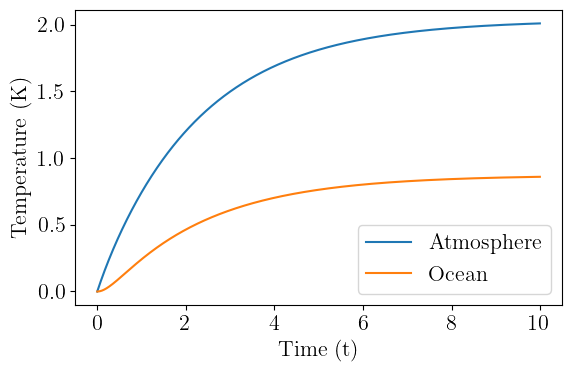

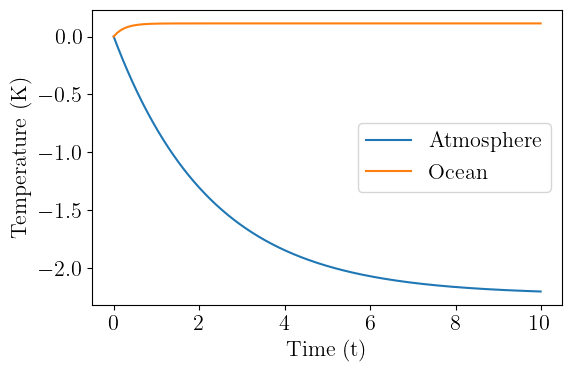

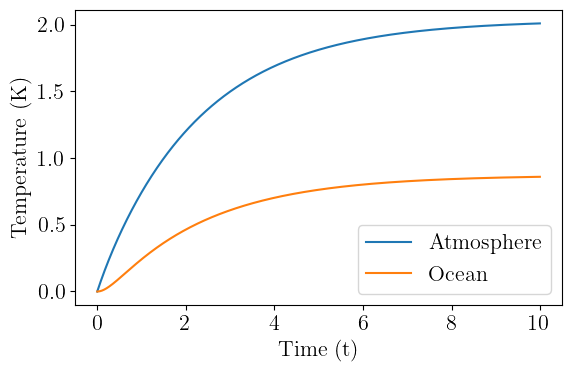

In [119]:
def coupled_to_uncoupled(L):
  lam_uncoup, G = np.linalg.eig(L)
  G_inv = np.linalg.inv(G)
  f_uncoup = G_inv[:,0]

  return lam_uncoup, f_uncoup, G

a_1, a_2, a_3 = 0.86, 1.5, 2.0
L = np.array([[a_1, -a_1], [-a_2, a_2 + a_3]])
F = 1.0

T_coup = np.zeros((len(t), 2))
T_coup[0] = np.array([0.0, 0.0])

for i in range(1, len(t)):
  T_coup[i] = T_coup[i-1] + coup_2_box(T_coup[i-1], F, L) * dt
plot_boxes(T_coup, t, n, labels)

lam_uncoup, f_uncoup, G = coupled_to_uncoupled(L)

T_uncoup = np.zeros((len(t), 2))
T_uncoup[0] = np.array([0.0, 0.0])

for i in range(1, len(t)):
  T_uncoup[i] = T_uncoup[i-1] + uncoup_2_box(T_uncoup[i-1], f_uncoup, F, lam_uncoup) * dt
plot_boxes(T_uncoup, t, n, labels)

for i in range(1, len(t)):
  T_uncoup[i] = np.dot(G, T_uncoup[i])
plot_boxes(T_uncoup, t, n, labels)


